In [1]:
!pip install transformers datasets

In [2]:
!pip install --upgrade datasets fsspec

  Using cached fsspec-2025.5.0-py3-none-any.whl.metadata (11 kB)


In [9]:
# -*- coding: utf-8 -*-

from datasets import load_dataset, DatasetDict,  concatenate_datasets
import torch
from transformers import BertTokenizer, DataCollatorForLanguageModeling, BertForSequenceClassification, default_data_collator
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os


ciphers = ['Rot13', 'Atbash', 'Polybius', 'Vigenere', 'Reverse', 'SwapPairs', 'ParityShift', 'DualAvgCode', 'WordShift']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def prepare_dataset():
    """
    Download dataset from HF. As there are mupltiple subsets, combine them into one for training
    """
    datasets = []
    for cipher in ciphers:
        ds = load_dataset("yu0226/CipherBank", cipher, split="test")
        ds = ds.map(lambda x: {'cipher_type': cipher})
        datasets.append(ds)

    dataset = concatenate_datasets(datasets)

    #splitting dataset
    dataset = dataset.shuffle(seed=12)
    split_dataset = dataset.train_test_split(test_size=0.2)

    dataset = DatasetDict({
        "train": split_dataset["train"],
        "test": split_dataset["test"]
    })

    return dataset


def massage_datasets(example):
    """
    Helper function for converting inputs into single string
    :param example: Sample input from the dataset
    :return: Formatted training string containing question and text
    """
    cipher_type = example["cipher_type"]
    ciphertext = example[cipher_type]

    input_text = f"Identify the cipher used in the ciphertext:\n{ciphertext}"

    return {"text": input_text}

def add_label(example):
    """
    Helper function for adding correct label
    :param example: Sample input from the dataset
    :return: Formatted training string containing correct label
    """
    return {"labels": ciphers.index(example["cipher_type"])}

def tokenize(tokenizer, example):
    """
    Helper for pre-tokenizing all examples.
    """
    tokenized = tokenizer(
        example["text"],
        #fixing length to avoid colab memory issue
        max_length=64,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    return tokenized

def process_dataset(dataset, tokenizer):
    dataset = dataset.map(massage_datasets)
    dataset = dataset.map(add_label)

    dataset = dataset.map(
        lambda example: tokenize(tokenizer, example),
        batched=True,
        remove_columns=["domain", "sub_domain", "plaintext", "cipher_type"] + ciphers
    )
    return dataset


def load_model():
    """
    load pretrained BERT model
    """
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    return model.to(device)

Device: cuda


Map:   0%|          | 0/1886 [00:00<?, ? examples/s]

Map:   0%|          | 0/472 [00:00<?, ? examples/s]

Map:   0%|          | 0/1886 [00:00<?, ? examples/s]

Map:   0%|          | 0/472 [00:00<?, ? examples/s]

Map:   0%|          | 0/1886 [00:00<?, ? examples/s]

Map:   0%|          | 0/472 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 0, step 0, loss 2.409609079360962


  2%|▏         | 2/118 [00:09<07:42,  3.99s/it]

Test loss:  2.2671007521947226


  8%|▊         | 10/118 [00:11<00:34,  3.13it/s]

Epoch 0, step 10, loss 1.7391726970672607


 10%|█         | 12/118 [00:20<03:50,  2.18s/it]

Test loss:  1.86483855565389


 17%|█▋        | 20/118 [00:22<00:30,  3.19it/s]

Epoch 0, step 20, loss 1.6458607912063599


 19%|█▊        | 22/118 [00:31<03:27,  2.16s/it]

Test loss:  1.5554993573824565


 25%|██▌       | 30/118 [00:33<00:26,  3.26it/s]

Epoch 0, step 30, loss 1.5387848615646362


 27%|██▋       | 32/118 [00:42<02:53,  2.02s/it]

Test loss:  1.4050043845176696


 34%|███▍      | 40/118 [00:43<00:23,  3.38it/s]

Epoch 0, step 40, loss 1.468001127243042


 36%|███▌      | 42/118 [00:52<02:29,  1.97s/it]

Test loss:  1.3263422759373982


 42%|████▏     | 50/118 [00:53<00:19,  3.44it/s]

Epoch 0, step 50, loss 1.2473132610321045


 44%|████▍     | 52/118 [01:02<02:09,  1.95s/it]

Test loss:  1.2280878698825837


 51%|█████     | 60/118 [01:03<00:16,  3.42it/s]

Epoch 0, step 60, loss 1.122189998626709


 53%|█████▎    | 62/118 [01:12<01:50,  1.97s/it]

Test loss:  1.1171765009562173


 59%|█████▉    | 70/118 [01:14<00:14,  3.40it/s]

Epoch 0, step 70, loss 0.8546798229217529


 61%|██████    | 72/118 [01:22<01:32,  2.00s/it]

Test loss:  0.8816838494936625


 68%|██████▊   | 80/118 [01:24<00:11,  3.37it/s]

Epoch 0, step 80, loss 0.9621595740318298


 69%|██████▉   | 82/118 [01:33<01:13,  2.04s/it]

Test loss:  0.7495449596643448


 76%|███████▋  | 90/118 [01:34<00:08,  3.32it/s]

Epoch 0, step 90, loss 0.7304591536521912


 78%|███████▊  | 92/118 [01:43<00:53,  2.06s/it]

Test loss:  0.5880521195133527


 85%|████████▍ | 100/118 [01:45<00:05,  3.31it/s]

Epoch 0, step 100, loss 0.9005919694900513


 86%|████████▋ | 102/118 [01:54<00:32,  2.05s/it]

Test loss:  0.6601274903615316


 93%|█████████▎| 110/118 [01:55<00:02,  3.31it/s]

Epoch 0, step 110, loss 0.6275165677070618


 95%|█████████▍| 112/118 [02:04<00:12,  2.03s/it]

Test loss:  0.4060575197140376


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 1, step 0, loss 0.24990390241146088


  2%|▏         | 2/118 [00:08<07:03,  3.65s/it]

Test loss:  0.3667502425114314


  8%|▊         | 10/118 [00:10<00:32,  3.37it/s]

Epoch 1, step 10, loss 0.1344776600599289


 10%|█         | 12/118 [00:19<03:33,  2.02s/it]

Test loss:  0.24177449653546015


 17%|█▋        | 20/118 [00:20<00:28,  3.38it/s]

Epoch 1, step 20, loss 0.19524402916431427


 19%|█▊        | 22/118 [00:29<03:11,  2.00s/it]

Test loss:  0.1558795067667961


 25%|██▌       | 30/118 [00:30<00:26,  3.37it/s]

Epoch 1, step 30, loss 0.11325407028198242


 27%|██▋       | 32/118 [00:39<02:52,  2.00s/it]

Test loss:  0.2908348265786966


 34%|███▍      | 40/118 [00:41<00:23,  3.36it/s]

Epoch 1, step 40, loss 0.07628241926431656


 36%|███▌      | 42/118 [00:50<02:33,  2.02s/it]

Test loss:  0.13525668608645597


 42%|████▏     | 50/118 [00:51<00:20,  3.36it/s]

Epoch 1, step 50, loss 0.23513811826705933


 44%|████▍     | 52/118 [01:00<02:13,  2.02s/it]

Test loss:  0.13668121103197337


 51%|█████     | 60/118 [01:02<00:17,  3.35it/s]

Epoch 1, step 60, loss 0.028020502999424934


 53%|█████▎    | 62/118 [01:10<01:53,  2.03s/it]

Test loss:  0.22192076553901036


 59%|█████▉    | 70/118 [01:12<00:14,  3.34it/s]

Epoch 1, step 70, loss 0.9271649122238159


 61%|██████    | 72/118 [01:21<01:32,  2.02s/it]

Test loss:  0.24318690276394286


 68%|██████▊   | 80/118 [01:22<00:11,  3.36it/s]

Epoch 1, step 80, loss 0.1993204653263092


 69%|██████▉   | 82/118 [01:31<01:12,  2.02s/it]

Test loss:  0.3615782495836417


 76%|███████▋  | 90/118 [01:33<00:08,  3.35it/s]

Epoch 1, step 90, loss 0.08699040859937668


 78%|███████▊  | 92/118 [01:42<00:52,  2.02s/it]

Test loss:  0.24798827905207874


 85%|████████▍ | 100/118 [01:43<00:05,  3.35it/s]

Epoch 1, step 100, loss 0.05118976905941963


 86%|████████▋ | 102/118 [01:52<00:32,  2.01s/it]

Test loss:  0.13876618715624014


 93%|█████████▎| 110/118 [01:53<00:02,  3.36it/s]

Epoch 1, step 110, loss 0.02604423649609089


 95%|█████████▍| 112/118 [02:02<00:12,  2.01s/it]

Test loss:  0.08004603020225962


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 2, step 0, loss 0.030458005145192146


  2%|▏         | 2/118 [00:08<07:04,  3.66s/it]

Test loss:  0.10129135025044282


  8%|▊         | 10/118 [00:10<00:32,  3.37it/s]

Epoch 2, step 10, loss 0.2736772894859314


 10%|█         | 12/118 [00:19<03:35,  2.03s/it]

Test loss:  0.1000018294279774


 17%|█▋        | 20/118 [00:20<00:29,  3.36it/s]

Epoch 2, step 20, loss 0.017176005989313126


 19%|█▊        | 22/118 [00:29<03:12,  2.01s/it]

Test loss:  0.09038372142861287


 25%|██▌       | 30/118 [00:31<00:26,  3.36it/s]

Epoch 2, step 30, loss 0.27430960536003113


 27%|██▋       | 32/118 [00:39<02:52,  2.01s/it]

Test loss:  0.3071982998897632


 34%|███▍      | 40/118 [00:41<00:23,  3.37it/s]

Epoch 2, step 40, loss 0.22647778689861298


 36%|███▌      | 42/118 [00:50<02:32,  2.01s/it]

Test loss:  0.17181116718798875


 42%|████▏     | 50/118 [00:51<00:20,  3.36it/s]

Epoch 2, step 50, loss 0.05563131347298622


 44%|████▍     | 52/118 [01:00<02:12,  2.01s/it]

Test loss:  0.2064466721378267


 51%|█████     | 60/118 [01:02<00:17,  3.37it/s]

Epoch 2, step 60, loss 0.02362135984003544


 53%|█████▎    | 62/118 [01:10<01:52,  2.01s/it]

Test loss:  0.0771950984497865


 59%|█████▉    | 70/118 [01:12<00:14,  3.36it/s]

Epoch 2, step 70, loss 0.017861176282167435


 61%|██████    | 72/118 [01:21<01:32,  2.01s/it]

Test loss:  0.05989692590509852


 68%|██████▊   | 80/118 [01:22<00:11,  3.37it/s]

Epoch 2, step 80, loss 0.12005321681499481


 69%|██████▉   | 82/118 [01:31<01:12,  2.01s/it]

Test loss:  0.10543811216329535


 76%|███████▋  | 90/118 [01:33<00:08,  3.37it/s]

Epoch 2, step 90, loss 0.015836201608181


 78%|███████▊  | 92/118 [01:41<00:52,  2.01s/it]

Test loss:  0.1825336603075266


 85%|████████▍ | 100/118 [01:43<00:05,  3.37it/s]

Epoch 2, step 100, loss 0.031877681612968445


 86%|████████▋ | 102/118 [01:52<00:32,  2.01s/it]

Test loss:  0.11831304120520751


 93%|█████████▎| 110/118 [01:53<00:02,  3.37it/s]

Epoch 2, step 110, loss 0.018459806218743324


 95%|█████████▍| 112/118 [02:02<00:12,  2.01s/it]

Test loss:  0.1087375676445663


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 3, step 0, loss 0.04351542517542839


  2%|▏         | 2/118 [00:08<07:03,  3.65s/it]

Test loss:  0.1739348376604418


  8%|▊         | 10/118 [00:10<00:32,  3.37it/s]

Epoch 3, step 10, loss 0.01648610085248947


 10%|█         | 12/118 [00:19<03:35,  2.04s/it]

Test loss:  0.12381097581858436


 17%|█▋        | 20/118 [00:20<00:29,  3.37it/s]

Epoch 3, step 20, loss 0.022649100050330162


 19%|█▊        | 22/118 [00:29<03:13,  2.01s/it]

Test loss:  0.20297598127896588


 25%|██▌       | 30/118 [00:31<00:26,  3.36it/s]

Epoch 3, step 30, loss 0.4575437605381012


 27%|██▋       | 32/118 [00:39<02:52,  2.01s/it]

Test loss:  0.431471294015646


 34%|███▍      | 40/118 [00:41<00:23,  3.34it/s]

Epoch 3, step 40, loss 0.08171825110912323


 36%|███▌      | 42/118 [00:50<02:32,  2.01s/it]

Test loss:  0.23888952429095903


 42%|████▏     | 50/118 [00:51<00:20,  3.35it/s]

Epoch 3, step 50, loss 0.13573676347732544


 44%|████▍     | 52/118 [01:00<02:12,  2.01s/it]

Test loss:  0.3000665639837583


 51%|█████     | 60/118 [01:02<00:17,  3.36it/s]

Epoch 3, step 60, loss 0.012956792488694191


 53%|█████▎    | 62/118 [01:10<01:52,  2.01s/it]

Test loss:  0.08047413235219816


 59%|█████▉    | 70/118 [01:12<00:14,  3.37it/s]

Epoch 3, step 70, loss 0.00981825590133667


 61%|██████    | 72/118 [01:21<01:32,  2.01s/it]

Test loss:  0.0818635119839261


 68%|██████▊   | 80/118 [01:22<00:11,  3.37it/s]

Epoch 3, step 80, loss 0.017801493406295776


 69%|██████▉   | 82/118 [01:31<01:12,  2.01s/it]

Test loss:  0.12660729209892452


 76%|███████▋  | 90/118 [01:33<00:08,  3.37it/s]

Epoch 3, step 90, loss 0.2684778869152069


 78%|███████▊  | 92/118 [01:41<00:52,  2.01s/it]

Test loss:  0.07254914487401644


 85%|████████▍ | 100/118 [01:43<00:05,  3.36it/s]

Epoch 3, step 100, loss 0.1815624088048935


 86%|████████▋ | 102/118 [01:52<00:32,  2.01s/it]

Test loss:  0.11208208033194145


 93%|█████████▎| 110/118 [01:53<00:02,  3.35it/s]

Epoch 3, step 110, loss 0.0571640208363533


 95%|█████████▍| 112/118 [02:02<00:12,  2.01s/it]

Test loss:  0.08226238394156099


  0%|          | 0/118 [00:00<?, ?it/s]

Epoch 4, step 0, loss 0.010966546833515167


  2%|▏         | 2/118 [00:08<07:03,  3.65s/it]

Test loss:  0.059296160343413555


  8%|▊         | 10/118 [00:10<00:32,  3.37it/s]

Epoch 4, step 10, loss 0.45285746455192566


 10%|█         | 12/118 [00:19<03:35,  2.04s/it]

Test loss:  0.07324633814084033


 17%|█▋        | 20/118 [00:20<00:29,  3.36it/s]

Epoch 4, step 20, loss 0.33142805099487305


 19%|█▊        | 22/118 [00:29<03:13,  2.01s/it]

Test loss:  0.050686635294308266


 25%|██▌       | 30/118 [00:31<00:26,  3.35it/s]

Epoch 4, step 30, loss 0.011126755736768246


 27%|██▋       | 32/118 [00:39<02:53,  2.02s/it]

Test loss:  0.05277945783299704


 34%|███▍      | 40/118 [00:41<00:23,  3.36it/s]

Epoch 4, step 40, loss 0.11977199465036392


 36%|███▌      | 42/118 [00:50<02:33,  2.02s/it]

Test loss:  0.07046023689831296


 42%|████▏     | 50/118 [00:51<00:20,  3.36it/s]

Epoch 4, step 50, loss 0.006904804613441229


 44%|████▍     | 52/118 [01:00<02:12,  2.02s/it]

Test loss:  0.17197444102105994


 51%|█████     | 60/118 [01:02<00:17,  3.34it/s]

Epoch 4, step 60, loss 0.39096853137016296


 53%|█████▎    | 62/118 [01:11<01:52,  2.02s/it]

Test loss:  0.3710506334217886


 59%|█████▉    | 70/118 [01:12<00:14,  3.36it/s]

Epoch 4, step 70, loss 0.010495999827980995


 61%|██████    | 72/118 [01:21<01:32,  2.02s/it]

Test loss:  0.09816956749185919


 68%|██████▊   | 80/118 [01:22<00:11,  3.36it/s]

Epoch 4, step 80, loss 0.017272530123591423


 69%|██████▉   | 82/118 [01:31<01:12,  2.02s/it]

Test loss:  0.12327275515223543


 76%|███████▋  | 90/118 [01:33<00:08,  3.36it/s]

Epoch 4, step 90, loss 0.005921115633100271


 78%|███████▊  | 92/118 [01:42<00:52,  2.01s/it]

Test loss:  0.09206541436103483


 85%|████████▍ | 100/118 [01:43<00:05,  3.36it/s]

Epoch 4, step 100, loss 0.02052498050034046


 86%|████████▋ | 102/118 [01:52<00:32,  2.01s/it]

Test loss:  0.11363017266926666


 93%|█████████▎| 110/118 [01:54<00:02,  3.36it/s]

Epoch 4, step 110, loss 0.008641679771244526


 95%|█████████▍| 112/118 [02:02<00:12,  2.01s/it]

Test loss:  0.05973898263337712


100%|██████████| 118/118 [02:04<00:00,  1.05s/it]


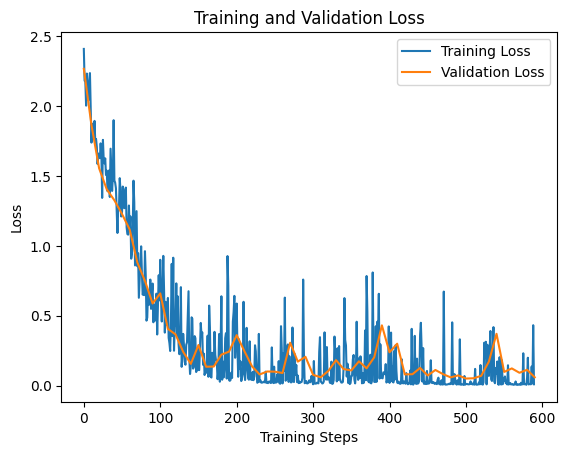

In [12]:
def train(model, train_loader, val_loader, train_steps, epochs=5, val_steps=150):
    # define optimizer and learning rate
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
    # define for losses accumulation
    losses = []
    validation_losses = []

    # get a batch of data
    dataloader_iter = iter(train_loader)
    # put the model in training mode
    model.train()

    # iterate over epochs
    for e in range(epochs):
        # iterate over training steps
        for i in tqdm(range(len(train_loader))):
          try:
              x = next(dataloader_iter)
          except StopIteration:
              dataloader_iter = iter(train_loader)
              x = next(dataloader_iter)

          # move the data to the device
          x = {k: v.to(device) for k, v in x.items()}

          # forward pass through the model
          outputs = model(**x)
          # get the loss
          loss = outputs.loss
          # backward pass
          loss.backward()
          # update the parameters of the model
          losses.append(loss.item())
          optimizer.step()
          # zero out gradient for next step
          optimizer.zero_grad()

          # evaluate on a few steps of validation set
          if i % 10 == 0:
              print(f"Epoch {e}, step {i}, loss {loss.item()}")
              val_loss = 0
              val_iter = iter(val_loader)
              for j in range(val_steps):
                try:
                  x_test = next(val_iter)
                except StopIteration:
                  val_iter = iter(val_loader)
                  x_test = next(val_iter)

                x_test = {k: v.to(device) for k, v in x_test.items()}
                with torch.no_grad():
                    test_outputs = model(**x_test)
                val_loss += test_outputs.loss.item()
              validation_losses.append(val_loss / val_steps)
              print("Test loss: ", val_loss / val_steps)

    return losses, validation_losses


def plot_losses(train_losses, val_losses, path="outputs/loss_plot.png"):
    plt.plot(train_losses, label="Training Loss")
    plt.plot([i * 10 for i in range(len(val_losses))], val_losses, label="Validation Loss")
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    os.makedirs(os.path.dirname(path), exist_ok=True)
    plt.savefig(path)
    plt.show()

def construct_test_samples(dataset):
    samples = []
    for i in range(10):
        example = dataset["test"][i]
        cipher_type = example["cipher_type"]
        ciphertext = example[cipher_type]
        input_text = f"Identify the cipher used in the ciphertext:\n{ciphertext}"
        samples.append({"text": input_text, "label": cipher_type})
    return samples

def evaluate(model, tokenizer, samples):
    predictions = []
    model.eval()

    for sample in samples:
        inputs = sample["text"]
        inputs = tokenizer(inputs, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            logits = outputs.logits

        predicted_class_id = logits.argmax(dim=-1).item()
        predicted_label = f"LABEL_{predicted_class_id}"

        predictions.append((sample["text"], predicted_label, sample["label"]))

    return predictions


def main():
    print("Device:", device)

    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    dataset = prepare_dataset()
    tokenized_dataset = process_dataset(dataset, tokenizer)

    model = load_model()

    collate_fn = default_data_collator

    train_dataset = tokenized_dataset["train"]
    validation_dataset = tokenized_dataset["test"]

    dataloader = DataLoader(
        train_dataset,
        batch_size=16,
        shuffle=True,
        collate_fn=collate_fn,
    )

    validation_dataloader = DataLoader(
        validation_dataset,
        batch_size=16,
        shuffle=True,
        collate_fn=collate_fn
    )

    train_steps = len(dataloader)

    train_losses, val_losses = train(
    model,
    dataloader,
    validation_dataloader,
    len(dataloader),
    5,
    150
)

    plot_losses(train_losses, val_losses)

    os.makedirs("saved_models", exist_ok=True)
    model.save_pretrained("saved_models/bert-cipher-classifier")
    tokenizer.save_pretrained("saved_models/bert-cipher-classifier")

    test_samples = construct_test_samples(dataset)
    predictions = evaluate(model, tokenizer, test_samples)

    os.makedirs("outputs", exist_ok=True)
    with open("outputs/predictions.txt", "w") as f:
        for i, (text, pred, true) in enumerate(predictions, 1):
            f.write(f"Example {i}:\nInput: {text}\nPredicted: {pred}\nTrue: {true}\n\n")
main()
